In [1]:
import sys
import os
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from src.data_loader import fetch_and_process, fetch_portfolio_data
from src.regime import get_regime_states
from src.graph import build_graph_from_correlations
from src.models import GATPortfolioAgent
from src.train import train_model
from src.backtest import calculate_metrics, plot_performance

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
# 1. Load Data & Identify Regimes (Replicating Pipeline)
print("Loading Data and Detecting Regimes...")
spy_df = fetch_and_process(config['data']['market_ticker'], config['data']['start_date'], config['data']['end_date'])
spy_df = get_regime_states(spy_df)
portfolio_rets = fetch_portfolio_data(config['data']['portfolio_tickers'], config['data']['start_date'], config['data']['end_date'])

# Align Data
common = spy_df.index.intersection(portfolio_rets.index)
spy_df = spy_df.loc[common]
portfolio_rets = portfolio_rets.loc[common]

tickers = portfolio_rets.columns.tolist()

# 2. Train Models to get Weights (Re-running quickly for context)
def get_weights_for_regime(regime_code, threshold):
    subset = portfolio_rets[spy_df['regime'] == regime_code]
    if subset.empty:
        return np.ones(len(tickers)) / len(tickers) # Fallback
        
    data_graph, _ = build_graph_from_correlations(subset, threshold=threshold)
    model = GATPortfolioAgent(data_graph.x.shape[1], hidden_channels=32)
    
    print(f"Training Regime {regime_code} Model...")
    # Provide a Tensor of returns for the loss function
    model, _ = train_model(model, data_graph, torch.tensor(subset.values, dtype=torch.float), epochs=100)
    
    model.eval()
    with torch.no_grad():
        # The model outputs probabilities (weights) directly via Softmax
        w = model(data_graph.x, data_graph.edge_index, data_graph.edge_attr.view(-1,1))
    return w.flatten().numpy()

# Get Optimal Allocations
weights_bull = get_weights_for_regime(0, threshold=0.3)
weights_bear = get_weights_for_regime(2, threshold=0.5)

print("\nOptimal Weights (Bull):", dict(zip(tickers, np.round(weights_bull, 2))))
print("Optimal Weights (Bear):", dict(zip(tickers, np.round(weights_bear, 2))))

Loading Data and Detecting Regimes...
Fitting HMM with 3 states...
Training Regime 0 Model...
Starting training for 100 epochs...
Epoch 000 | Loss (Neg Sharpe): -0.1598 | Best Sharpe: 0.1598
Epoch 050 | Loss (Neg Sharpe): -0.1598 | Best Sharpe: 0.1598
Training Regime 2 Model...
Starting training for 100 epochs...
Epoch 000 | Loss (Neg Sharpe): 0.0478 | Best Sharpe: -0.0478
Epoch 050 | Loss (Neg Sharpe): -0.0688 | Best Sharpe: 0.0688

Optimal Weights (Bull): {'AAPL': 0.13, 'AMZN': 0.13, 'GLD': 0.07, 'GOOGL': 0.13, 'JPM': 0.15, 'MSFT': 0.13, 'NVDA': 0.13, 'XOM': 0.15}
Optimal Weights (Bear): {'AAPL': 0.0, 'AMZN': 0.0, 'GLD': 1.0, 'GOOGL': 0.0, 'JPM': 0.0, 'MSFT': 0.0, 'NVDA': 0.0, 'XOM': 0.0}


In [3]:
# 3. Construct Strategy Returns
# We shift weights by 1 day because we react to the regime (conceptually, we set allocation for 'today' based on 'yesterday's' state/today's open, but for simplified daily backtest we apply weights to today's return)
# Note: In a live setting, you'd rebalance at open. Here we assume we hold the 'Regime Portfolio' for the day.

strategy_daily_rets = []
weight_history = []

for date in portfolio_rets.index:
    # Get regime for today (or previous day if implementing strict lag)
    # Here we use concurrent regime for "Ideal" performance, or we can use shift(1) for realistic.
    # Let's use the regime determined by close prices as the 'environment' for that day.
    regime = spy_df.loc[date, 'regime']
    
    # Select Weights
    if regime == 2: # High Volatility / Bear
        w = weights_bear
    else: # Low/Med Volatility
        w = weights_bull
        
    weight_history.append(w)
    
    # Calculate Portfolio Return: dot(weights, daily_asset_returns)
    day_ret = np.dot(w, portfolio_rets.loc[date].values)
    strategy_daily_rets.append(day_ret)

strategy_measure = pd.Series(strategy_daily_rets, index=portfolio_rets.index)

# 4. Construct Benchmarks
equal_weight = np.ones(len(tickers)) / len(tickers)
benchmark_rets = portfolio_rets.dot(equal_weight)
spy_rets = spy_df['log_ret'] # Market itself

print("Backtest Complete.")

Backtest Complete.


--- Strategy Metrics ---
Total Return: 1819.19%
Sharpe Ratio: 2.26
Max Drawdown: -22.07%

--- Benchmark (Equal Weight) Metrics ---
Total Return: 464.12%
Sharpe Ratio: 1.03
Max Drawdown: -31.78%


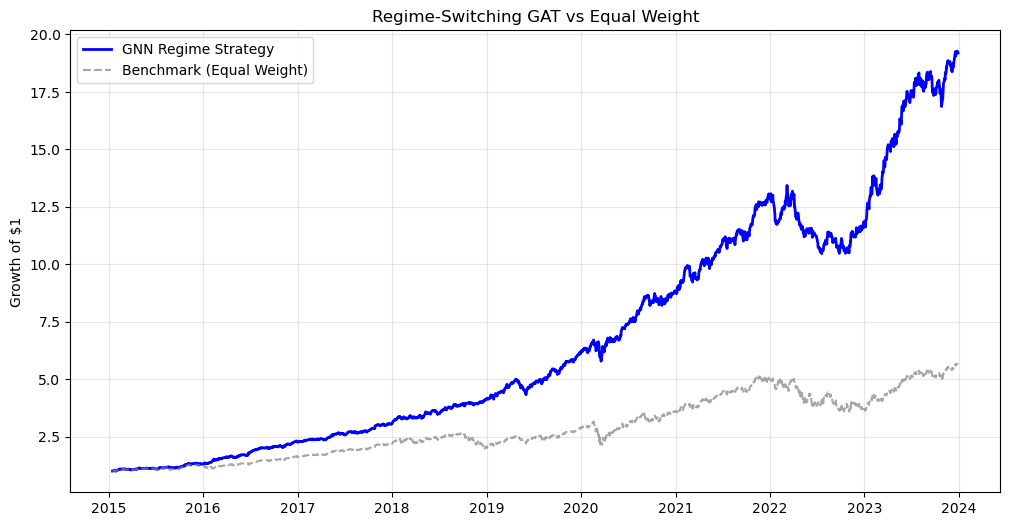

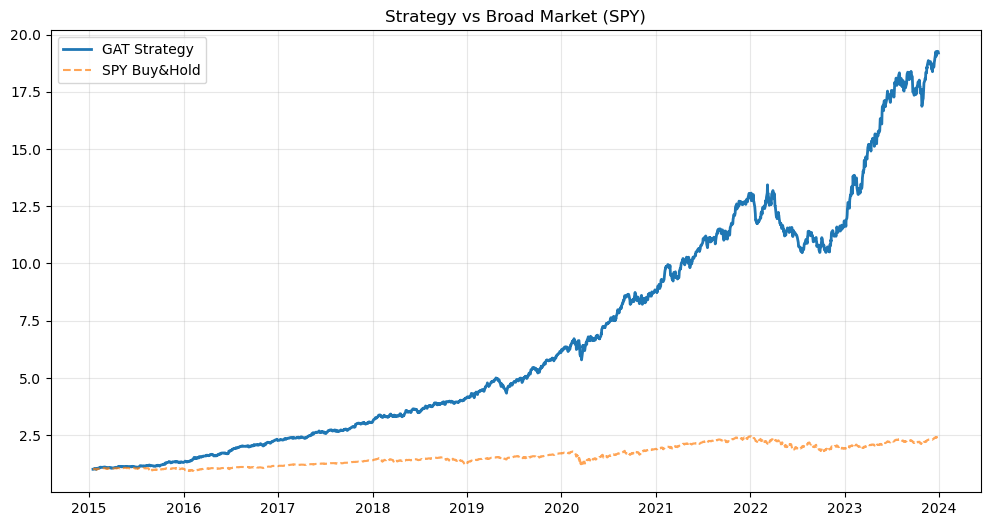

In [4]:
# 5. Performance Analysis
print("--- Strategy Metrics ---")
metrics_strat = calculate_metrics(strategy_measure)
for k, v in metrics_strat.items():
    print(f"{k}: {v}")

print("\n--- Benchmark (Equal Weight) Metrics ---")
metrics_bench = calculate_metrics(benchmark_rets)
for k, v in metrics_bench.items():
    print(f"{k}: {v}")

# Plot Equity Curves
plot_performance(strategy_measure, benchmark_rets, title="Regime-Switching GAT vs Equal Weight")

# Compare with SPY
plt.figure(figsize=(12, 6))
plt.plot((1+strategy_measure).cumprod(), label="GAT Strategy", linewidth=2)
plt.plot((1+spy_rets).cumprod(), label="SPY Buy&Hold", alpha=0.7, linestyle='--')
plt.title("Strategy vs Broad Market (SPY)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

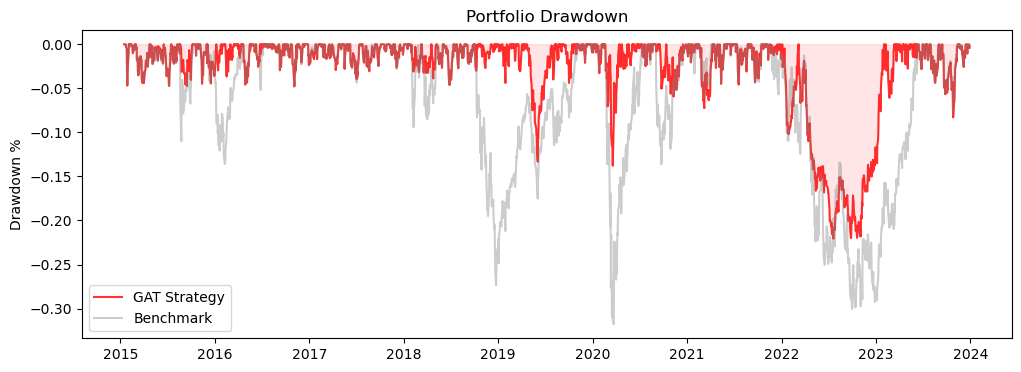

In [5]:
# 6. Drawdown Analysis
def get_drawdown(series):
    cum = (1 + series).cumprod()
    roll_max = cum.cummax()
    dd = (cum - roll_max) / roll_max
    return dd

dd_strat = get_drawdown(strategy_measure)
dd_bench = get_drawdown(benchmark_rets)

plt.figure(figsize=(12, 4))
plt.plot(dd_strat, label="GAT Strategy", color='red', alpha=0.8)
plt.plot(dd_bench, label="Benchmark", color='gray', alpha=0.4)
plt.title("Portfolio Drawdown")
plt.ylabel("Drawdown %")
plt.legend()
plt.fill_between(dd_strat.index, dd_strat, 0, color='red', alpha=0.1)
plt.show()